## CSCI 470 SATGazers


In [1]:
!pip install pyephem
!pip install skyfield
!pip install pyproj

     |████████████████████████████████| 380 kB 2.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 40 kB 3.4 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 258 kB 2.3 MB/s            
  Created wheel for skyfield: filename=skyfield-1.40-py3-none-any.whl size=425560 sha256=327c68bcdf5d8e7c3bf0920e066f587b665ca0e508acf2ab0e870a56a930e048
  Stored in directory: /home/jacob/.cache/pip/wheels/56/a3/b2/64446948752ff6bc07dcc4f6d1c6969fd7ddb6e91264d5d2aa
  Created wheel for jplephem: filename=jplephem-2.16-py3-none-any.whl size=46775 sha256=e11d167804c34478eabdc66ae7ffa90ab456d986f554218c4a06b17370a2121f
  Stored in directory: /home/jacob/.cache/pip/wheels/32/6c/56/475357f9ee778f1995ba2be80c79e0fdded7162e1dc3ddc578
Successfully built skyfield jplephem
     |████████████████████████████████| 5.8 MB 3.6 MB/s            


In [56]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

plt.style.use("ggplot")
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
sat_28884 = pd.read_json("./28884.json")
sat_13552 = pd.read_json("./13552.json")
sat_19608 = pd.read_json("./19608.json")
sat_48006 = pd.read_json("./48006.json")
sat_33379 = pd.read_json("./33379.json")
sat_33468 = pd.read_json("./33468.json")

In [186]:
# ignore cell, based on previous version


longs = []
lats = []
elevations = []
          
for i, entry in sat_48006.iterrows():
  name = entry['TLE_LINE0']
  line1 = entry['TLE_LINE1']
  line2 = entry['TLE_LINE2']
  epoch = entry['EPOCH']
  
  tle_rec = ephem.readtle(name, line1, line2)
  tle_rec.compute(epoch)

  longs.append(tle_rec.sublong)
  lats.append(tle_rec.sublat)
  elevations.append(tle_rec.elevation)
  
sat_48006['LONGITUDE'] = np.array(longs)
sat_48006['LATITUDE'] = np.array(lats)
sat_48006['ELEVATION'] = np.array(elevations)

In [4]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw


In [211]:
# Data inspection
L1, L2 = sat_48006.iloc[0]['TLE_LINE1'], sat_48006.iloc[0]['TLE_LINE2']
sat_48006.iloc[0]
date = sat_48006.iloc[0]['EPOCH']
d = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
date_28884.year

2021

[#################################] 100% de421.bsp


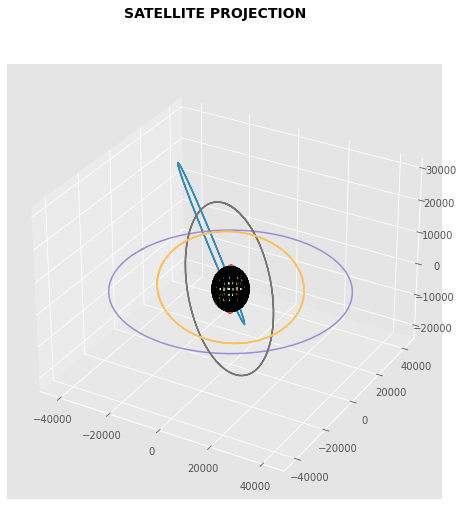

In [7]:
from skyfield.api import load, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ephem
import datetime
import math, pyproj

def plotaxislimit(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw


halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180

sats = []
all_sats = [sat_13552, sat_19608, sat_28884, sat_33379, sat_33468, sat_48006]
for sat in all_sats:
  entry = sat.iloc[math.floor(len(sat)/2)]
  SatL1, SatL2 = entry['TLE_LINE1'], entry['TLE_LINE2']
  date = datetime.datetime.strptime(entry['EPOCH'], "%Y-%m-%d %H:%M:%S")
  
  tmp_sat = dict(name=entry['OBJECT_NAME'], L1=SatL1, L2=SatL2, year=date.year, month=date.month, day=date.day)
  sats.append(tmp_sat)


data = load('de421.bsp')
ts   = load.timescale()

planets = load('de421.bsp')
earth   = planets['earth']

eSats = []
hours = np.arange(0, 24.3, 0.30)

for s in sats:
  Sat = EarthSatellite(s['L1'], s['L2'], name=s['name'])
  eSats.append(Sat)
  time = ts.utc(s['year'], s['month'], s['day'], hours)
  s['pos'] = Sat.at(time).position.km
  s['posecl'] = Sat.at(time).ecliptic_position().km


re = 6378.

theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)


figPlot = plt.figure(figsize=[10, 8])
figPlot.suptitle('SATELLITE PROJECTION', fontsize=14, fontweight='bold')
axdet  = figPlot.add_subplot(1, 1, 1, projection='3d')
for Sat in sats:
    x, y, z = Sat['pos']
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 8500, Sat03.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')

  

plt.show()


In [8]:
# An example of generated positions (x,y,z)
sats[0]['pos']

array([[  680.36614051,  -998.02671344, -1431.44985641,   -83.57870567,
         1367.86934003,  1123.72195052,  -511.15529869, -1507.49887478,
         -625.87153427,  1032.73119029,  1410.56261342,    41.94755873,
        -1375.9361966 , -1078.40309671,   559.17916936,  1502.98186156,
          584.92966234, -1056.2132443 , -1379.93345797,    13.04339301,
         1389.66736663,  1043.81573247,  -593.82381872, -1490.04013415,
         -530.48769938,  1087.46618645,  1356.85098189,   -53.62467461,
        -1394.67304869,  -997.2236808 ,   639.06868715,  1482.51116111,
          489.60505498, -1108.24958878, -1323.91615941,   106.95166453,
         1404.92819104,   961.65809524,  -671.67052969, -1466.66634801,
         -435.47679074,  1136.05198903,  1298.85171316,  -146.33487601,
        -1406.90483326,  -914.04781027,   714.02778882,  1456.30989748,
          394.83388058, -1154.09626647, -1263.81737307,   197.7985304 ,
         1413.80270446,   877.70798568,  -744.49051023, -1437.69

In [70]:
all_sats = pd.DataFrame(pd.read_json("./10000_sats.json"))

,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,...,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,GENERATED VIA SPACETRACK.ORG API,18 SPCS,34761,COSMOS 2251 DEB,DEBRIS,U,93036AAF,2021-11-28 00:00:03,653856,14.307648,...,0 COSMOS 2251 DEB,1 34761U 93036AAF 21332.00004229 .00000354 0...,2 34761 74.0297 182.9087 0043634 216.8055 143...,1993-036AAF,34761,7167.312,100.645,820.451,757.904,0.0
1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,41917,IRIDIUM 106,PAYLOAD,U,17003A,2021-11-28 00:00:05,990112,14.342200,...,0 IRIDIUM 106,1 41917U 17003A 21332.00006933 .00000114 0...,2 41917 86.3989 63.1223 0002037 88.6723 271...,2017-003A,41917,7155.797,100.403,779.119,776.204,0.0
2,GENERATED VIA SPACETRACK.ORG API,18 SPCS,26930,PICOSAT 9,PAYLOAD,U,01043B,2021-11-28 00:00:14,440032,14.307583,...,0 PICOSAT 9,1 26930U 01043B 21332.00016713 -.00000039 0...,2 26930 66.9992 167.1101 0003548 225.8704 134...,2001-043B,26930,7167.334,100.646,791.742,786.656,0.0
3,GENERATED VIA SPACETRACK.ORG API,18 SPCS,30281,FENGYUN 1C DEB,DEBRIS,U,99025YS,2021-11-28 00:00:18,245952,14.086378,...,0 FENGYUN 1C DEB,1 30281U 99025YS 21332.00021118 .00000047 0...,2 30281 98.7296 346.0670 0030644 93.5250 287...,1999-025YS,30281,7242.174,102.226,886.232,841.846,0.0
4,GENERATED VIA SPACETRACK.ORG API,18 SPCS,43172,YAOGAN-30 M,PAYLOAD,U,18011D,2021-11-28 00:00:33,351264,14.900619,...,0 YAOGAN-30 M,1 43172U 18011D 21332.00038601 .00000333 0...,2 43172 34.9977 86.5298 0003732 42.0217 318...,2018-011D,43172,6975.879,96.640,600.348,595.141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,GENERATED VIA SPACETRACK.ORG API,18 SPCS,48662,STARLINK-2726,PAYLOAD,U,21044AA,2021-11-28 07:32:15,638496,15.063919,...,0 STARLINK-2726,1 48662U 21044AA 21332.31406989 .00000355 0...,2 48662 53.0571 285.3890 0001750 58.2335 301...,2021-044AA,48662,6925.373,95.593,548.450,546.026,0.0
9996,GENERATED VIA SPACETRACK.ORG API,18 SPCS,48895,SPACEBEE-108,PAYLOAD,U,21059S,2021-11-28 07:32:15,981504,15.127554,...,0 SPACEBEE-108,1 48895U 21059S 21332.31407386 .00003276 0...,2 48895 97.5337 98.9342 0011040 81.7094 278...,2021-059S,48895,6905.938,95.191,535.427,520.179,0.0
9997,GENERATED VIA SPACETRACK.ORG API,18 SPCS,831,ELEKTRON 3 DEB,DEBRIS,U,64038C,2021-11-28 07:32:15,934848,12.057869,...,0 ELEKTRON 3 DEB,1 00831U 64038C 21332.31407332 .00005564 0...,2 00831 60.7192 252.8602 1575711 292.9331 51...,1964-038C,831,8033.192,119.424,2920.855,389.258,0.0
9998,GENERATED VIA SPACETRACK.ORG API,18 SPCS,48906,UMBRA-2001,PAYLOAD,U,21059AD,2021-11-28 07:32:15,135648,15.107851,...,0 UMBRA-2001,1 48906U 21059AD 21332.31406407 .00005986 0...,2 48906 97.5253 98.7948 0009967 45.6889 314...,2021-059AD,48906,6911.941,95.315,540.695,526.917,0.0


In [487]:
# Get features from our TLE data
features = []
for i,sat in all_sats.iterrows():
    if i % 100 == 0 and i != 0:
        break
    features.append(sat.drop(['COMMENT','ORIGINATOR','NORAD_CAT_ID','OBJECT_NAME','OBJECT_TYPE','CLASSIFICATION_TYPE','EPOCH_MICROSECONDS','INTLDES','EPOCH','FILE', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2','OBJECT_ID','OBJECT_NUMBER']))

In [413]:
# Get tracking data for 10000 satellites
sats = []

for i,sat in all_sats.iterrows():
    entry = sat
    SatL1, SatL2 = entry['TLE_LINE1'], entry['TLE_LINE2']
    date = datetime.datetime.strptime(entry['EPOCH'], "%Y-%m-%d %H:%M:%S")
  
    tmp_sat = dict(name=entry['OBJECT_NAME'], L1=SatL1, L2=SatL2, year=date.year, month=date.month, day=date.day)
    sats.append(tmp_sat)


data = load('de421.bsp')
ts   = load.timescale()

planets = load('de421.bsp')
earth   = planets['earth']

eSats = []
hours = np.arange(0, 24.3, 0.30)

for s in sats:
  Sat = EarthSatellite(s['L1'], s['L2'], name=s['name'])
  eSats.append(Sat)
  time = ts.utc(s['year'], s['month'], s['day'], hours)
  s['pos'] = Sat.at(time).position.km
  s['posecl'] = Sat.at(time).ecliptic_position().km



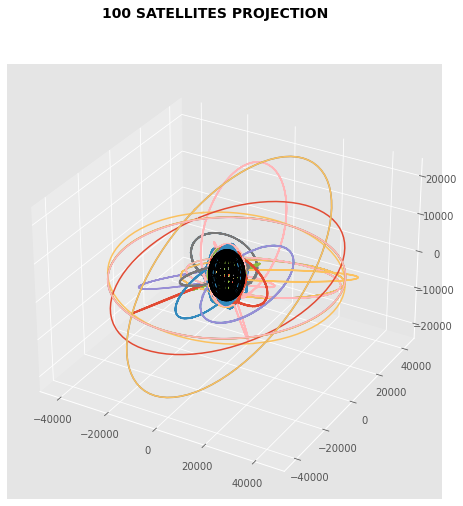

In [414]:
# Plotting all 10000 sats will take about 20 minutes, not worth it
figPlot = plt.figure(figsize=[10, 8])
figPlot.suptitle('100 SATELLITES PROJECTION', fontsize=14, fontweight='bold')
axdet  = figPlot.add_subplot(1, 1, 1, projection='3d')
for Sat in sats[0:100]:
    x, y, z = Sat['pos']
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 8500, Sat03.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')

  

plt.show()

IndexError: index 81 is out of bounds for axis 0 with size 81

In [488]:
# Now create features including time-offsets from hours 
complete_features = []
for i, f in enumerate(features):
  # Combine the position of the satellites with the appropriate hour
  if i % 200 == 0:
        print(i,"/1000")
  
  for h_i, h in enumerate(hours):
    tmp = f.copy(deep=True)
    x = sats[i]['pos'][0][h_i]
    y = sats[i]['pos'][1][h_i]
    z = sats[i]['pos'][2][h_i]
    
    tmp['HOURS'] = h
    tmp['X'] = x
    tmp['Y'] = y
    tmp['Z'] = z
    complete_features.append(tmp)

0 /1000


In [489]:
df = pd.DataFrame(complete_features).dropna()

In [523]:
# Create feature arrays for 3 targets
sat_X_features = df.copy(deep=True)[['HOURS']]
sat_X_target = df[['X','Y','Z']]


In [524]:
x_train, x_test, y_train, y_test = train_test_split(sat_X_features, sat_X_target, test_size=0.2, random_state=0)

In [525]:
x_train.shape

(6480, 1)

In [493]:
y_train.shape

(6480, 1)

In [510]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scale = min_max_scaler.fit_transform(x_train, y_train)
x_test = min_max_scaler.transform(x_test)

In [494]:
y_train
y_test

,X
32,31957.709624
36,2835.135775
19,-4361.857493
36,3260.033209
92,-551.855236
...,...
9,-28919.521495
23,523.047154
91,1840.788047
77,2661.647345


In [526]:
# Create models
from tensorflow.keras.models import Model

inp = Input(1)
l = Dense(100, activation='linear')(inp)
l = Dropout(0.1)(l)
l = Dense(100, activation='linear')(l)
l = Dropout(0.10)(l)
l = Dense(100, activation='linear')(l)
l = Dropout(0.05)(l)
l = Dense(30, activation='linear')(l)
out = Dense(3, name="output_layer")(l)
        

Xmodel = Model(inputs=inp, outputs=out)
Xmodel.compile(loss='msle', optimizer='sgd', metrics=['accuracy'])

In [527]:
# Now fit the model
n_epochs = 20
history = Xmodel.fit(x_train, y_train, batch_size=10, epochs=n_epochs)

Epoch 1/20
648/648 [==============================] - 0s 359us/step - loss: 23.2844 - accuracy: 0.3386
Epoch 2/20
648/648 [==============================] - 0s 352us/step - loss: 23.0517 - accuracy: 0.3355
Epoch 3/20
648/648 [==============================] - 0s 354us/step - loss: 22.9797 - accuracy: 0.3353
Epoch 4/20
648/648 [==============================] - 0s 357us/step - loss: 22.9554 - accuracy: 0.3356
Epoch 5/20
648/648 [==============================] - 0s 356us/step - loss: 22.9402 - accuracy: 0.3355
Epoch 6/20
648/648 [==============================] - 0s 355us/step - loss: 22.9373 - accuracy: 0.3356
Epoch 7/20
648/648 [==============================] - 0s 356us/step - loss: 22.9143 - accuracy: 0.3355
Epoch 8/20
648/648 [==============================] - 0s 360us/step - loss: 22.8916 - accuracy: 0.3355
Epoch 9/20
648/648 [==============================] - 0s 352us/step - loss: 17.4976 - accuracy: 0.3343
Epoch 10/20
648/648 [==============================] - 0s 352us/step - lo

In [531]:
y_pred = Xmodel.predict(x_test)
print(y_pred,y_test)

[[80.69676  65.52876  50.046715]
 [84.09883  68.496284 51.455666]
 [61.985413 49.207375 42.297523]
 ...
 [71.624596 57.61536  46.289536]
 [86.93388  70.969215 52.629784]
 [64.25345  51.185726 43.236816]]                X             Y            Z
32  31957.709624 -13725.478580  4687.153619
36   2835.135775   -502.776044  6595.409069
19  -4361.857493   5259.325168  2561.440507
36   3260.033209  -1502.573655 -6257.349367
92   -551.855236   -925.049023 -6831.255840
..           ...           ...          ...
9  -28919.521495 -10791.254556 -5427.155504
23    523.047154    -12.746575  7028.790897
91   1840.788047  -1370.583663 -6607.737212
77   2661.647345  41735.961333  6592.509424
72    691.733462 -17909.852663 -4351.988151

[1620 rows x 3 columns]


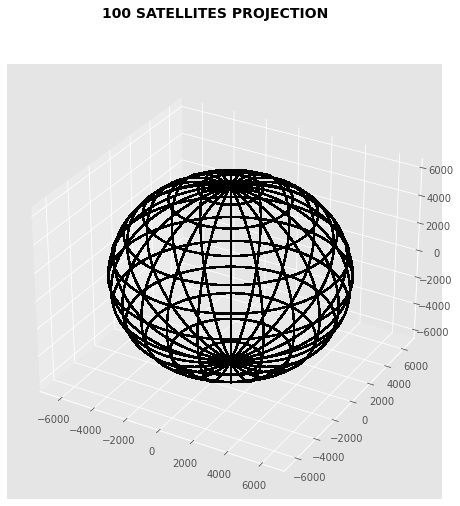

In [533]:
figPlot = plt.figure(figsize=[10, 8])
figPlot.suptitle('100 SATELLITES PROJECTION', fontsize=14, fontweight='bold')
axdet  = figPlot.add_subplot(1, 1, 1, projection='3d')
for p in y_pred:
    x, y, z = p
    axdet.plot(x, y, z)
    #ax.text(5500, 500, 8500, Sat03.name)
    for x, y, z in lons:
        axdet.plot(x, y, z, '-k')
    for x, y, z in lats:
        axdet.plot(x, y, z, '-k')

  

plt.show()

Now let's try another optimizer instead of stochastic gradient descent (SGD). [Adam](https://keras.io/optimizers/#adam) is the recommended default for training neural networks since it usually performs quite well. In the next cell, compile the model with Adam instead of SGD and use the same loss and metrics. After compiling, fit the data for as many epochs as you think it takes to see the value start to converge.

In [ ]:
# - Instantiate an Adam optimizer with learning rate of 1e-5, and save it as "optimizer"
# - Recompile the model using Adam and the same loss and metrics as previously
# - Call .fit() to train you model, using a batch size of 1000. You choose the number of epochs.
# - Note that we are now using a larger learning rate, so convergence
#   should occur more quickly.

# Before starting, we'll reset the model parameters back to their original,
# random state, so we aren't trying to train an already trained model.
model.set_weights(initial_weights)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert isinstance(model.optimizer, keras.optimizers.Adam)
assert model.loss in ["mae", "mean_absolute_error"]

In [ ]:
# You can optionally visualize the model here, with some added package installs.

# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Let's plot the training loss and metric scores again

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'])
plt.title('Training set loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.semilogy(np.arange(1, n_epochs+1), history.history['mae'], label='mae')
plt.semilogy(np.arange(1, n_epochs+1), history.history['mse'], label='mse')
plt.legend()
plt.title('Training set metric scores')
plt.xlabel('Epoch')
plt.ylabel('Error')

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")

In [ ]:
model.evaluate(x_test, y_test)

Now recreate the model, again named `model`, with dropout layers. Add two dropout layers, using [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), one after the first layer of neurons and one after the second layer of neurons.
Create a new list of layers, and name it `layers`, rather than reusing your old list (so that the model parameters will be randomly initialized again). Then construct the model as before.
Select a low value of dropout (say, <0.1) that results in a good score.

In [ ]:
# Create your new model, with dropout layers.

# YOUR CODE HERE
raise NotImplementedError()


In [ ]:
model.summary()

In [ ]:
assert len(layers) == 6
assert isinstance(layers[1], Dropout)
assert isinstance(layers[3], Dropout)
for i,layer in enumerate(layers):
    if i not in [1,3]:
        assert isinstance(layers[i], keras.layers.Dense) 
        assert layer.weights[1].shape == [100, 0, 100, 0, 100, 1][i]

In [ ]:
# Because dropout reduces the convergence rate (but may ultimately coverge to
# a lower loss), it sometimes requires training for more epochs than otherwise.

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', "mse"])
n_epochs = 50
history = model.fit(x_train, y_train, batch_size=1000, epochs=n_epochs, verbose=1)

In [ ]:
# Let's plot the training loss and metric scores again

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs+1), history.history['loss'])
plt.title('Training set loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.semilogy(np.arange(1, n_epochs+1), history.history['mae'], label='mae')
plt.semilogy(np.arange(1, n_epochs+1), history.history['mse'], label='mse')
plt.legend()
plt.title('Training set metric scores')
plt.xlabel('Epoch')
plt.ylabel('Error')

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")

In [ ]:
model.evaluate(x_test, y_test)

Select a dropout rate that gets an okay score--one that is sufficient to pass the following `assert` test.

Note that in this case, dropout did not likely result in better loss or metric scores on the test set versus the models without dropout. Dropout does not always help, but it sometimes does, especially if you have a very large model but a somewhat undersized dataset. In that case, dropout serves as a regularization technique, like L1- or L2-norm weight penalty terms in linear regression.

In [ ]:
assert model.evaluate(x_test, y_test)[0] < 3

## Feedback